# Dependencies

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""
# If you're using Google Colab and not running locally, run this cell.
!pip install torchaudio

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

# install beam search decoder
!apt-get install -y swig
!git clone https://github.com/NVIDIA/NeMo -b "$BRANCH"
!cd NeMo && bash scripts/asr_language_modeling/ngram_lm/install_beamsearch_decoders.sh

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()
from IPython.display import clear_output
clear_output()

# Imports

In [ ]:
import os

import nemo
import nemo.collections.asr as nemo_asr
import torch

from asr.visualisation import play_audio, print_err_html
from asr.models import BeamSearchDecoderWithLM
from asr.datasets import LibriSpeechBookDataset

import nltk
from nltk import word_tokenize

from gensim.corpora import Dictionary
from gensim.models.hdpmodel import HdpModel

import matplotlib.pyplot as plt
from IPython.display import clear_output
clear_output()

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Setup complete. Using torch 1.9.0+cu102 CPU


In [ ]:
def get_best_transcriptions(transcriptions):
    return list(map(lambda xs: xs[0][1], transcriptions))

def download_lm(lm_path):
    %rm -v "{lm_path}"*
    !wget "https://www.openslr.org/resources/11/{lm_path}.gz" -O "{lm_path}.gz"
    !gzip -cdv "{lm_path}.gz" > "{lm_path}"

def download_from_github(file_id, file_name):
    %rm -v "{file_name}"
    !wget "{file_id}" -O "{file_name}"

In [ ]:
nltk.download("punkt")

MODEL_NAME='stt_en_jasper10x5dr'
LM_3GRAM_PATH = '3-gram.arpa'
ID2WORD_MODEL_PATH = "id2word.dict"
ID2WORD_MODEL_FILEID = "https://github.com/alexjercan/asr-toolkit/releases/download/v1.0/id2word.dict"
LDA_MODEL_PATH = "lda_model.model"
LDA_MODEL_FILEID = "https://github.com/alexjercan/asr-toolkit/releases/download/v1.0/lda_model.model"
ROOT = os.path.join(".")

asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name=MODEL_NAME, strict=False).to(DEVICE)
asr_model.eval()

VOCABULARY = list(map(lambda x: x.upper(), asr_model.decoder.vocabulary))
vocab = VOCABULARY + ['<pad>']
BLANK = len(vocab) - 1 

DICTIONARY = dict(zip(vocab, range(len(vocab))))
LABELS = {v:k for k, v in DICTIONARY.items()}

if not os.path.exists(LM_3GRAM_PATH):
    download_lm(LM_3GRAM_PATH)
beam_search_lm = BeamSearchDecoderWithLM(
    vocab=VOCABULARY,
    beam_width=16,
    alpha=1.5, beta=1.5,
    lm_path=LM_3GRAM_PATH,
    num_cpus=max(os.cpu_count(), 1))

if not os.path.exists(LDA_MODEL_PATH):
    download_from_github(LDA_MODEL_FILEID, LDA_MODEL_PATH)
lda_model = HdpModel.load(LDA_MODEL_PATH)

if not os.path.exists(ID2WORD_MODEL_PATH):
    download_from_github(ID2WORD_MODEL_FILEID, ID2WORD_MODEL_PATH)
id2word = Dictionary.load(ID2WORD_MODEL_PATH)

num_topics = len(lda_model.get_topics())
topic_keywords = [([word for word, prop in lda_model.show_topic(t)]) for t in range(num_topics)]

test_dataset = LibriSpeechBookDataset(root=ROOT, url="test-clean", folder_in_archive="LibriSpeech", download=True)

clear_output()

# Complete pipeline

In [ ]:
audiobook_signal, audiobook_gt_transcription, audiobook_title, audiobook_duration = next(iter(test_dataset))

In [ ]:
print(f"The book is \"{audiobook_title}\" and has a duration of {audiobook_duration} minutes.")
play_audio(audiobook_signal, sample_rate=16_000)

In [ ]:
input_signal = audiobook_signal[0].to(DEVICE).unsqueeze(0)
input_signal_length = torch.tensor([audiobook_signal.shape[-1]], device=DEVICE)

with torch.no_grad():
    log_probs, encoded_len, greedy_predictions = asr_model(input_signal=input_signal, input_signal_length=input_signal_length)
    transcriptions = beam_search_lm(log_probs=log_probs, log_probs_length=encoded_len)

audiobook_text = get_best_transcriptions(transcriptions)[0]
_, _ = print_err_html(audiobook_gt_transcription.split(" "), audiobook_text.split(" "))

[NeMo W 2021-08-23 15:32:39 patch_utils:50] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-08-23 15:32:40 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
    To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
      return torch.floor_divide(self, other)
    


ERR=8.0838


In [ ]:
x = word_tokenize(audiobook_text.lower())
x = id2word.doc2bow(x)
y_hat = lda_model[[x]]

Predicted topic for the book "Shakespeare's Sonnets" are
9 and contains ['incomplete', 'assiduously', 'unpleasantly', 'avert', 'repel', 'soothes', 'clouds', 'nettle', 'amass', 'digest', 'proven', 'forenoon', 'stress', 'promontory', 'cigarettes', 'lavish', 'myth', 'reek', 'vastly', 'receptacle'] keywords.
14 and contains ['quoth', 'covenant', 'shingle', 'serenity', 'accidental', 'bowing', 'cucumber', 'inveterate', 'snuff', 'bleeding', 'contemptible', 'garter', 'thrice', 'recited', 'satan', 'robertson', 'compels', 'propagandists', 'bomb', 'wickedly'] keywords.


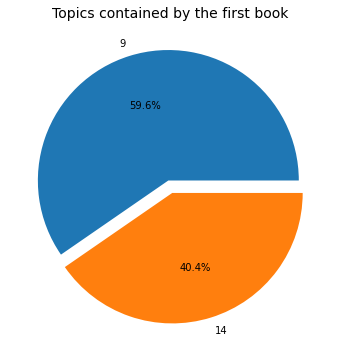

In [ ]:
_threshold = 0.05
data = {k: v for k, v in y_hat[0] if v >= _threshold}
topics = sorted(data.items(), key=lambda e: e[1], reverse=True)
print(f"Predicted topic for the book \"{audiobook_title}\" are")
for k, v in topics:
    print(f"{k} and contains {topic_keywords[k]} keywords.")

pie, ax = plt.subplots(figsize=[10, 6])

plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys(), normalize=True)
plt.title("Topics contained by the first book", fontsize=14)
plt.show()

# Extra

In [ ]:
from pprint import pprint

In [ ]:
pprint(lda_model.print_topics(num_words=20))

[(0,
  '0.002*deceitful + 0.002*sits + 0.002*opium + 0.002*fated + 0.002*ferns + '
  '0.001*cuban + 0.001*winked + 0.001*thigh + 0.001*smiling + '
  '0.001*submissively + 0.001*squarely + 0.001*trash + 0.001*depict + '
  '0.001*sky + 0.001*eligible + 0.001*memorandum + 0.001*improper + '
  '0.001*corroborate + 0.001*jolt + 0.001*impediment'),
 (1,
  '0.002*footpath + 0.002*forgetting + 0.002*leaned + 0.002*sill + '
  '0.002*impostor + 0.001*essence + 0.001*antidote + 0.001*contented + '
  '0.001*famously + 0.001*episode + 0.001*grocery + 0.001*straightforward + '
  '0.001*jungle + 0.001*dissatisfy + 0.001*trophy + 0.001*entrench + '
  '0.001*reasoning + 0.001*eject + 0.001*slang + 0.001*sportive'),
 (2,
  '0.002*quail + 0.002*cheque + 0.001*predominant + 0.001*velocity + '
  '0.001*dairy + 0.001*affront + 0.001*promoter + 0.001*lightest + '
  '0.001*expulsion + 0.001*rap + 0.001*rhetoric + 0.001*despotic + '
  '0.001*naturedly + 0.001*doughnut + 0.001*ached + 0.001*ecclesiastic + '
  '